<a href="https://colab.research.google.com/github/NancyBudgujjar/brain_tumor/blob/main/LSTM_wheat_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow -U

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import pickle

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [4]:
rot = tf.keras.layers.RandomRotation(factor=0.2)
flip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")

def augment(images):
    for i in range(len(images)):
        flipped = flip(images[i])
        images[i] = rot(flipped)

    return images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#import os
#os.chdir('/content/drive/MyDrive/projects/Brain_tumor')
#db="/content/drive/MyDrive/projects/Brain_tumor"

In [7]:
#labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
labels = ['Brown_rust','Healthy','Yellow_rust']
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/project/Wheat_disease_detection/data','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        #img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        X_train.append(img)
        y_train.append(i)

100%|██████████| 924/924 [00:14<00:00, 62.34it/s] 


In [8]:

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/project/Wheat_disease_detection/data','val',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        #img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        X_train.append(img)
        y_train.append(i)

100%|██████████| 232/232 [00:02<00:00, 79.20it/s]


In [9]:
'''
from sklearn import preprocessing

x_train_norm = preprocessing.normalize(X_train.reshape(-1, 32*32*3))
y_train_norm = preprocessing.normalize(y_train.reshape(-1, 32*32*3))   '''

'\nfrom sklearn import preprocessing\n\nx_train_norm = preprocessing.normalize(X_train.reshape(-1, 32*32*3))\ny_train_norm = preprocessing.normalize(y_train.reshape(-1, 32*32*3))   '

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
X_train.shape, y_train.shape

((3679, 150, 150, 3), (3679,))

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [13]:
#X_train = np.vstack(X_train)
X_train = np.vstack((X_train, augment(X_train)))

In [14]:
y_train = np.vstack((y_train, y_train.copy()))

In [13]:
X_train.shape, y_train.shape

((3679, 150, 150, 3), (3679, 3))

In [14]:
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
X_train.shape, X_test.shape

((2943, 150, 150, 3), (736, 150, 150, 3))

In [17]:
r50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [21]:
X_train_preds = r50.predict(X_train)

92/92 [==============================] - 268s 3s/step


In [18]:
X_test_preds = r50.predict(X_test)

23/23 [==============================] - 73s 3s/step


In [22]:
X_train_preds.shape, X_test_preds.shape

((2943, 5, 5, 2048), (736, 5, 5, 2048))

In [25]:
X_train_features = np.zeros((2943, 1, 51200))
for i in range(2943): #5875
    X_train_features[i] = X_train_preds[i].reshape((1, 51200))
                            #653
X_test_features = np.zeros((736, 1, 51200))
for i in range(736):                                 #100352
    X_test_features[i] = X_test_preds[i].reshape((1, 51200))

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(512, input_shape=(1, 51200), activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 512)            105908224 
                                                                 
 dropout_4 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 256)            787456    
                                                                 
 dropout_5 (Dropout)         (None, 1, 256)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 128)            197120    
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 64)               

In [29]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [30]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("bestomodelo.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [31]:
history = model.fit(X_train_features, y_train, validation_split=0.1, epochs=12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.7704
Epoch 1: val_accuracy improved from -inf to 0.95593, saving model to bestomodelo.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 243s 3s/step - loss: 0.5417 - accuracy: 0.7704 - val_loss: 0.1328 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9626
Epoch 2: val_accuracy improved from 0.95593 to 0.97966, saving model to bestomodelo.h5
83/83 [==============================] - 226s 3s/step - loss: 0.1264 - accuracy: 0.9626 - val_loss: 0.0570 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9713
Epoch 3: val_accuracy improved from 0.97966 to 0.98983, saving model to bestomodelo.h5
83/83 [==============================] - 241s 3s/step - loss: 0.1110 - accuracy: 0.9713 - val_loss: 0.0242 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9864
Epoch 4: val_accuracy did not improve from 0.98983
83/83 [==============================] - 218s 3s/step - loss: 0.

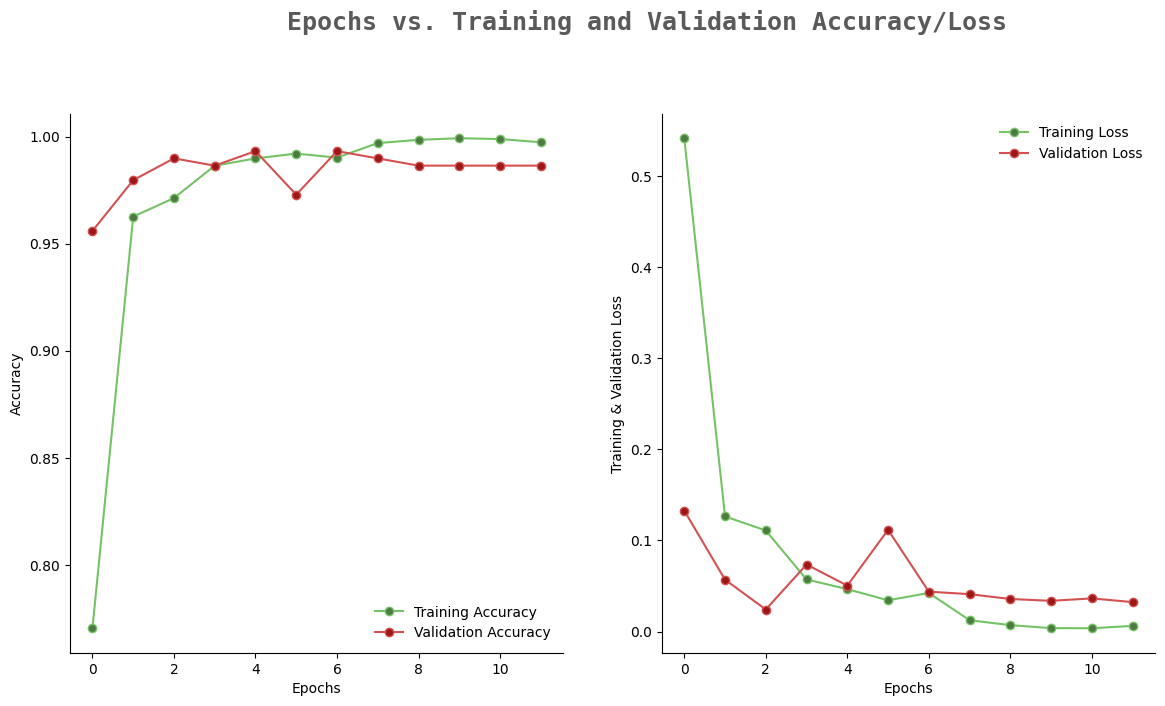

In [32]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [33]:
model.evaluate(X_test_features, y_test)

23/23 [==============================] - 5s 195ms/step - loss: 0.1536 - accuracy: 0.9783


[0.1536046266555786, 0.97826087474823]

In [34]:
pred = model.predict(X_test_features)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

23/23 [==============================] - 5s 191ms/step


In [35]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       216
           1       0.98      1.00      0.99       290
           2       0.98      0.97      0.98       230

    accuracy                           0.98       736
   macro avg       0.98      0.98      0.98       736
weighted avg       0.98      0.98      0.98       736



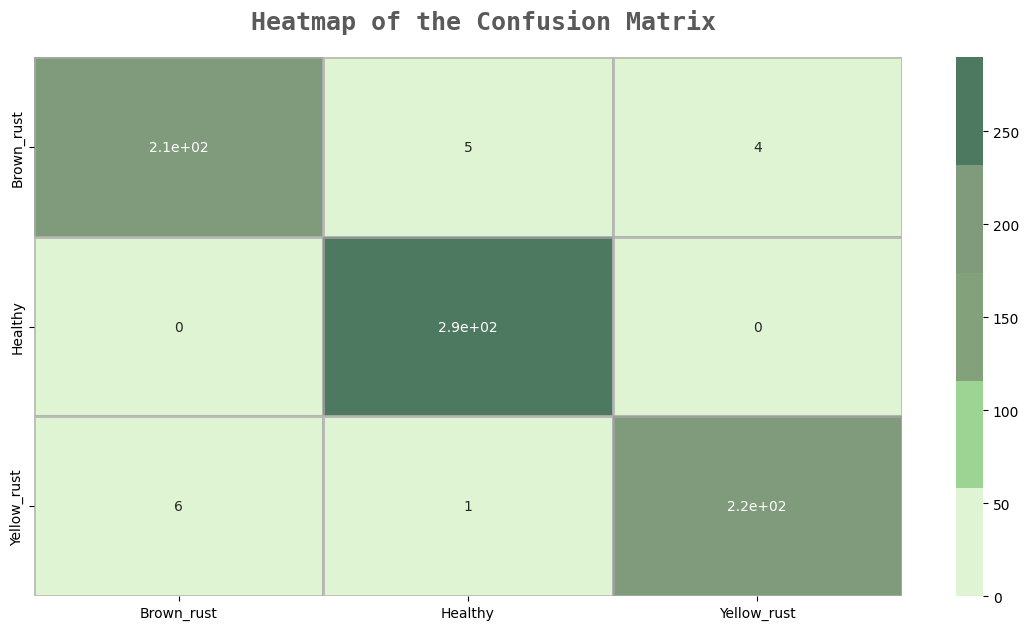

In [36]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)
plt.show()